In [66]:
import pandas as pd
import pymysql
import getpass

import seaborn as sns
sns.set()

import numpy as np

In [5]:
conn = pymysql.connect(host="35.233.174.193",port=3306,
                       user="alec",passwd=getpass.getpass("Enter password for MIMIC2 database"),
                       db='PHS')

Enter password for MIMIC2 database········


In [47]:
query = """
SELECT 
	a.subject_id
    ,a.hadm_id
    ,disch_dt
    ,dod
    ,p.sex
    ,d.ethnicity_descr
    ,DATEDIFF(disch_dt, dob) / 365 age_at_discharge
    ,CASE 
		WHEN CAST(DATEDIFF(disch_dt, dob) / 365 AS SIGNED) < 18 THEN '<18'
        WHEN CAST(DATEDIFF(disch_dt, dob) / 365 AS SIGNED) BETWEEN 18 AND 35 THEN '18-35'
        WHEN CAST(DATEDIFF(disch_dt, dob) / 365 AS SIGNED) BETWEEN 36 AND 65 THEN '36-65'
        WHEN CAST(DATEDIFF(disch_dt, dob) / 365 AS SIGNED) BETWEEN 66 AND 90 THEN '66-90'
        ELSE '91+'
    END AS age_at_discharge_binned
    ,CASE WHEN pna.hadm_id IS NULL THEN 0 ELSE 1 END AS pna
    ,DATEDIFF(dod, disch_dt) time_to_death
    ,CASE WHEN CAST(DATEDIFF(dod, disch_dt) AS SIGNED) <= 30 THEN 1 ELSE 0 END AS mortality_30_day
    FROM mimic2.admissions a
    LEFT OUTER JOIN (
        SELECT DISTINCT
        dx.hadm_id
    FROM PHS.value_set_value val
        INNER JOIN PHS.value_set vs
            ON val.value_set_id = vs.value_set_id
        INNER JOIN mimic2.icd9 dx 
            ON val.code_value = dx.code
    WHERE vs.value_set_name = 'icd9_pneumonia'
    ) pna
		ON a.hadm_id = pna.hadm_id
	INNER JOIN mimic2.d_patients p
		ON a.subject_id = p.subject_id
	INNER JOIN mimic2.demographic_detail d
		ON a.hadm_id = d.hadm_id
WHERE disch_dt != dod;
"""

In [48]:
df = pd.read_sql(query, conn)

/Users/alecchapman/opt/miniconda3/envs/phs/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [49]:
df.head()

,subject_id,hadm_id,disch_dt,dod,sex,ethnicity_descr,age_at_discharge,age_at_discharge_binned,pna,time_to_death,mortality_30_day
0,37,18052,3264-08-19 00:00:00,3265-12-31 00:00:00,M,WHITE,68.9863,66-90,1,499,0
1,78,15161,2778-03-27 00:00:00,2781-03-11 00:00:00,M,BLACK/AFRICAN AMERICAN,48.6658,36-65,0,1080,0
2,3,2075,2682-09-18 00:00:00,2683-05-02 00:00:00,M,WHITE,76.6055,66-90,0,226,0
3,26,15067,3079-03-10 00:00:00,3080-12-22 00:00:00,M,UNKNOWN/NOT SPECIFIED,72.0712,66-90,0,653,0
4,61,7149,3352-07-26 00:00:00,3353-02-09 00:00:00,M,WHITE,54.7808,36-65,0,198,0


In [50]:
len(df)

3407

In [51]:
df["hadm_id"].value_counts()

18052    1
12600    1
12237    1
16265    1
22931    1
        ..
22613    1
1757     1
2013     1
1169     1
29529    1
Name: hadm_id, Length: 3407, dtype: int64

In [52]:
df.to_csv("./pna_30_day_mortality.csv")

In [53]:
len(df)

3407

In [54]:
df["mortality_30_day"].mean()

0.1332550631053713

/Users/alecchapman/opt/miniconda3/envs/phs/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='time_to_death', ylabel='Density'>

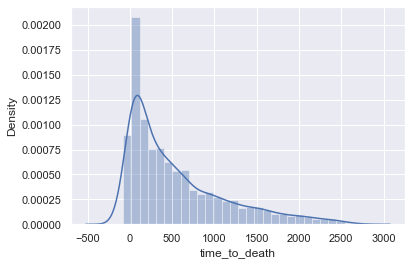

In [60]:
sns.distplot(df["time_to_death"])

In [68]:
twobytwo = pd.crosstab(df["pna"], df["mortality_30_day"]).sort_index(ascending=False)[[1, 0]]
twobytwo

mortality_30_day,1,0
pna,,
1,96,516
0,358,2437


In [69]:
(96 * 2347) / (516 * 358)

1.2196959854488763